# Discover Sentinel 1 data using the EODC STAC catalog

This notebook demonstrates how to access radar data in a STAC Catalogue using the pystac library. In this examples we use here Sentinel-1 data on the EODC stac catalog. In the further process we will learn how to query a STAC catalog, select specific items and display their metadata.

In [1]:
import pystac_client
import folium
from odc import stac as odc_stac

In [2]:
eodc_catalog = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1"
    )

eodc_catalog

<Client id=stac-fastapi>

Each catalog, composed by different providers, has many collections. To get all collections of a catalog, we can print all of them and their ids, which are used to fetch them from the catalog. 

In [3]:
collections = eodc_catalog.get_collections()

# length of string of collection.id, for pretty print
max_length = max(len(collection.id) for collection in collections)

for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

SENTINEL2_L2A                     : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                 : Multi-Layer Copernicus Sentinel-2 GRI in L1C
DOP_AUT_K_OSTTIROL                : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
SENTINEL1_HPAR                    : SENTINEL1 Harmonic Parameters
AUT_DEM                           : Austrian High Resolution DEM
COP_DEM                           : Copernicus Digital Elevation Model (DEM)
DOP_AUT_K_KLAGENFURT              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_WOLFSBERG               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
SENTINEL1_MPLIA                   : SENTINEL1 Mean PLIA
SENTINEL1_SLC                     : Sentinel-1 SLC
SENTINEL1_GRD                     : Sentinel-1 SAR L1 GRD
AI4SAR_SIG0                       : AI4SAR Despeckled Sentinel-1 Sigma0 (20m)
SENTINEL3_SRAL_L2                 : Sentin

To get a specific collection from the catalog, we can use the `client.get_collection()` method and provide the collection name. We can then display its description, id, temporal and spatial extend, licence, etc.

In [4]:
colllection_id = 'SENTINEL1_SIG0_20M'

collection = eodc_catalog.get_collection(colllection_id)
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

Each collection has multiple items. An item is one spatio-temporal instance the collection, for instance a satellite image. If items are needed for a specific timeframe or for a specific region of interest, we can define this as a query.

In [5]:
time_range = "2022-10-01/2022-10-07"  # a closed range
# time_range = "2022-01"  # whole month, same can be done for a year and a day
# time_range = "2022-01-01/.."  # up to the current date, an open range
# time_range = "2022-01-01T05:34:46"  # a specific time instance

A spatial region of interest can be defined in different ways. One option is to define a simple bounding box:

To make the code cleaner, the following bounding box could be used, but generally any area of the world can be selected as polygon (does not have to be a rectangle) with geojson.io and `interescts`.

In [6]:
latmin, latmax = 46.3, 49.3  # South to North
lonmin, lonmax = 13.8, 17.8  # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

If the region of interest is not rectengular, we can also define a polygon:

In [7]:
# GEOJSON can be created on geojson.io

# This specific area of interest is a rectangle, but since it is
# a closed polygon it seems like it has five nodes

area_of_interest = {
    "coordinates": [
          [
            [
              17.710928010825853,
              49.257630084442496
            ],
            [
              13.881798300915221,
              49.257630084442496
            ],
            [
              13.881798300915221,
              46.34747715326259
            ],
            [
              17.710928010825853,
              46.34747715326259
            ],
            [
              17.710928010825853,
              49.257630084442496
            ]
          ]
        ],
        "type": "Polygon"
        }

Using our previously loaded STAC catalog, we can now search for items fullfilling our query. In this example we are using the bounding box. If we want to use an area of interest specified in the geojson format - one hast to use the intersects parameter as documented in the comment below.

In [8]:
search = eodc_catalog.search(
    collections=colllection_id,  # can also be a list of several collections
    bbox=bounding_box,  # search by bounding box
    # intersects=area_of_interest,  # GeoJSON search
    datetime=time_range,
    # max_items = 1  # number of max items to load
    )

# If we comment everything besides colllection_id, we will load whole
# collection for available region and time_range

items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 52 items for the given search query


Now, we can fetch a single item, in this case a Sentinel-1 image, from the query results. A good practice is to always check what metadata the data provider has stored on the item level.

In [9]:
item = items_eodc[0]
item

<Item id=SIG0_20221007T170811_A117_E048N015T3_EU020M_V1M1R1_S1AIWGRDH>

Lets display only VV polarisation of the item and some information about the data.

In [10]:
item.assets['VV'].extra_fields.get('raster:bands')[0]

{'scale': 10,
 'nodata': -9999,
 'offset': 0,
 'data_type': 'int16',
 'spatial_resolution': 20}

In the EODC STAC catalogue an item can conveniently be displayed using its thumbnail.

In [11]:
item.assets['thumbnail'].href

'https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E048N015T3/SIG0_20221007T170811__VV_A117_E048N015T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail'

Here is a way to quickly check how the data found by a search query looks on a map.

In [12]:
map = folium.Map(location=[(latmin+latmax)/2, (lonmin+lonmax)/2],
                 zoom_start=7,
                 zoom_control=False,
                 scrollWheelZoom=False,
                 dragging=False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

for item in items_eodc:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets['thumbnail'].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]],
                [bounds[3], bounds[2]]],  # bounds of item
                ).add_to(map)

folium.LayerControl().add_to(map)

map

## Data Reading

STAC can also be a useful tool for the discovery of data, however it only loads metadata. This saves memory, but if one would like to do further analysis the data has to be loaded into memory or downloaded on disk.

The library we use here for loading the data is called `odc-stac`.


In [13]:
bands = ("VV", "VH")
crs = "EPSG:4326"  # Coordinate Reference System -
# World Geodetic System 1984 (WGS84) in this case
res = 0.00018  # 20 meter in degree

sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time': 1,
                                'latitude': 1000,
                                'longitude': 1000},
                        resolution=res,
                        bbox=bounding_box
                        )

Lets display for example the VV band of the dataset.

In [14]:
sig0_ds.VV

<xarray.DataArray 'VV' (time: 31, latitude: 16667, longitude: 22223)> Size: 23GB
dask.array<VV, shape=(31, 16667, 22223), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 133kB 49.3 49.3 49.3 49.3 ... 46.3 46.3 46.3
  * longitude    (longitude) float64 178kB 13.8 13.8 13.8 ... 17.8 17.8 17.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2022-10-01T05:09:56 ... 2022-10-0...
Attributes:
    nodata:   -9999

Displayed data is "lazily" loaded, which means that structure of DataArray is constructed, but data is not loaded yet. It is loaded only at instance when it is needed, for example plotting, computing and so on. `Xarray` is convenient for multidimensional labeled arrays, like temperature, humidity, pressure, different bands of satellite imagery and so on.  [The link](https://docs.xarray.dev/en/stable/index.html) to the `xarray` documentation.

Nevertheless, it is better to choose smaller area, since the array is too big.

In [15]:
latmin_smaller, latmax_smaller = 48, 48.4
lonmin_smaller, lonmax_smaller = 16, 16.5

smaller_bounding_box = [[latmin_smaller, lonmin_smaller],
                        [latmax_smaller, lonmax_smaller]]

map = folium.Map(location=[(latmin_smaller+latmax_smaller)/2,
                           (lonmin_smaller+lonmax_smaller)/2],
                           zoom_start=8,
                 zoom_control=False,
                 scrollWheelZoom=False,
                 dragging=False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

folium.Rectangle(
    bounds=smaller_bounding_box,
    color="red",
    ).add_to(map)

for item in items_eodc:
    image_url = item.assets['thumbnail'].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
        ).add_to(map)

folium.LayerControl().add_to(map)

map

In [16]:
sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time': 1,
                                'latitude': 1000,
                                'longitude': 1000},
                        resolution=res,
                        bbox=[lonmin_smaller, latmin_smaller,
                              lonmax_smaller, latmax_smaller],
                        # groupby='time'
                        )

sig0_ds.VV

<xarray.DataArray 'VV' (time: 31, latitude: 2223, longitude: 2779)> Size: 383MB
dask.array<VV, shape=(31, 2223, 2779), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 18kB 48.4 48.4 48.4 48.4 ... 48.0 48.0 48.0
  * longitude    (longitude) float64 22kB 16.0 16.0 16.0 16.0 ... 16.5 16.5 16.5
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2022-10-01T05:09:56 ... 2022-10-0...
Attributes:
    nodata:   -9999

Now dataset is considerably smaller. Lets plot first time instance.

/home/ljovic/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/ljovic/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/ljovic/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


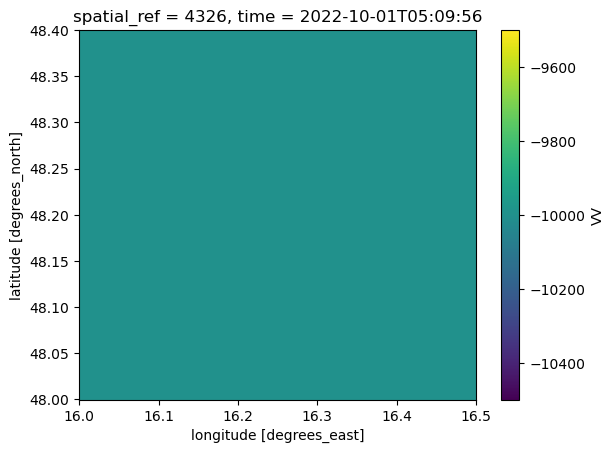

In [17]:
sig0_ds.VV.isel(time=0).plot()

Due to the way the data is acquired and stored, some items include "no data" areas. In our case, no data has the value -9999, but this can very from data provider to data provider. This information can usually be found in the metadata. Furthermore, to save the memory, data is often stored as integer (e.g. 25) and not at float (e.g. 2.5) format. For this reason, the backscatter values are often multiplied by a scale factor, in this case the factor 10.

As Sentinel-1 satellites overpasses Austria every few days and does acquisition of backscatter for few minutes, only some part of dataset will have physical data. So it is better to take daily averages (average scene that Sentinel observed for few minutes of overpass) and to see how it looks over whole week (that was previously defined in STAC search).

Note: cell belows will take some time to run.

In [18]:
# raster:bands is STAC raster extension
scale = item.assets['VV'].extra_fields.get('raster:bands')[0]['scale']
nodata = item.assets['VV'].extra_fields.get('raster:bands')[0]['nodata']

sig0_ds = sig0_ds.where(sig0_ds!=nodata) / scale

# We should remove unnecessary dates when there was no dataa
# (no satellite overpass)
sig0_ds = sig0_ds.dropna(dim='time')

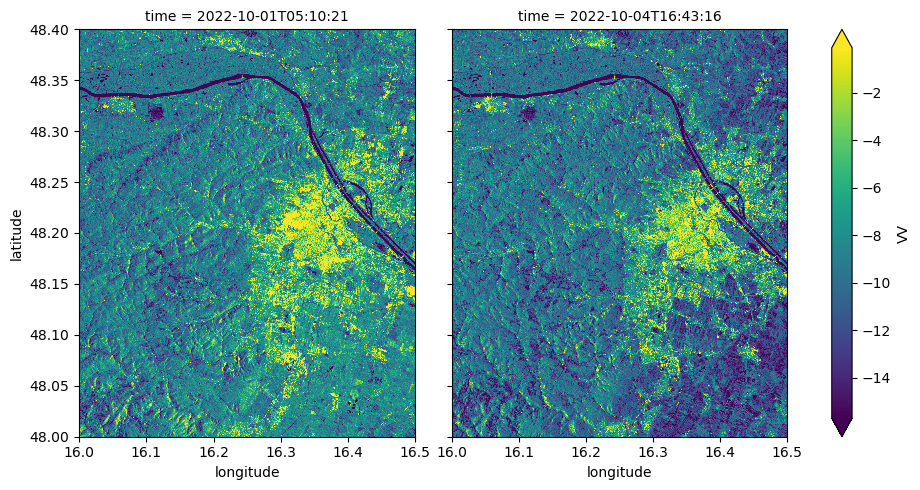

In [19]:
sig0_ds.VV.plot(col='time', col_wrap=2, robust=True, figsize=(10, 5))